# 영업 성공 여부 분류 경진대회

## [Timeline]
### 1. EDA
### 2. 데이터 전처리
### 3. 모델 학습
### 4. 교차 검증
### 5. 파라미터 튜닝
### 6. 모델 평가 
### 7. 예측 및 제출

## 1. EDA

### 필수 라이브러리

In [76]:
# 기본 라이브러리
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import statsmodels.api as sm
import re
from sklearn import set_config
%matplotlib inline

# 시각화 및 폰트
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', family='Malgun Gothic') # 폰트 지정
plt.rc('axes', unicode_minus=False) # 마이너스 폰트 설정
%config InlineBackend.figure_format='retina' # 그래프 글씨 뚜렷

# 전처리 관련 라이브러리
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, OrdinalEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer 
import category_encoders as ce
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SequentialFeatureSelector,SelectPercentile
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

# 훈련 및 평가 관련 라이브러리
from sklearn.model_selection import train_test_split, ShuffleSplit,cross_val_score, cross_validate, KFold
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score, precision_score, recall_score)

# 모델 라이브러리
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import xgboost as xgb

# 파라미터 튜닝 관련 라이브러리
# import optuna
# from optuna.distributions import CategoricalDistribution, IntDistribution, FloatDistribution
# from optuna.integration import OptunaSearchCV, ShapleyImportanceEvaluator

### 데이터 셋 읽어오기

In [215]:
df_train = pd.read_csv("./data/train.csv") # 학습용 데이터
df_test = pd.read_csv("./data/submission.csv") # 테스트 데이터(제출파일의 데이터)

df = pd.concat([df_train,df_test])
df_train = df[:59299]
df_test = df[59299:]
df.tail()

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted,id
5266,0.50,/São Paulo/Brazil,AS,NaN,40292,NaN,Enterprise,10.0,NaN,NaN,...,NaN,0,0,NaN,NaN,NaN,NaN,97,False,13855.0
5267,0.25,General / / United States,IT,NaN,47466,NaN,Enterprise,0.0,NaN,NaN,...,NaN,0,0,NaN,NaN,NaN,NaN,438,False,7979.0
5268,0.75,/ OURO BRANCO / Brazil,AS,NaN,46227,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,less than 3 months,0,0,NaN,NaN,NaN,NaN,97,True,12887.0
5269,0.00,/ / Germany,IT,NaN,45667,End Customer,SMB,NaN,NaN,NaN,...,NaN,0,0,NaN,NaN,NaN,NaN,429,False,17530.0
5270,0.25,/ Ongole / India,AS,NaN,23646,End Customer,Enterprise,NaN,NaN,NaN,...,NaN,0,0,NaN,NaN,NaN,NaN,4,True,4330.0


### 칼럼별 고유값 확인

- is_converted

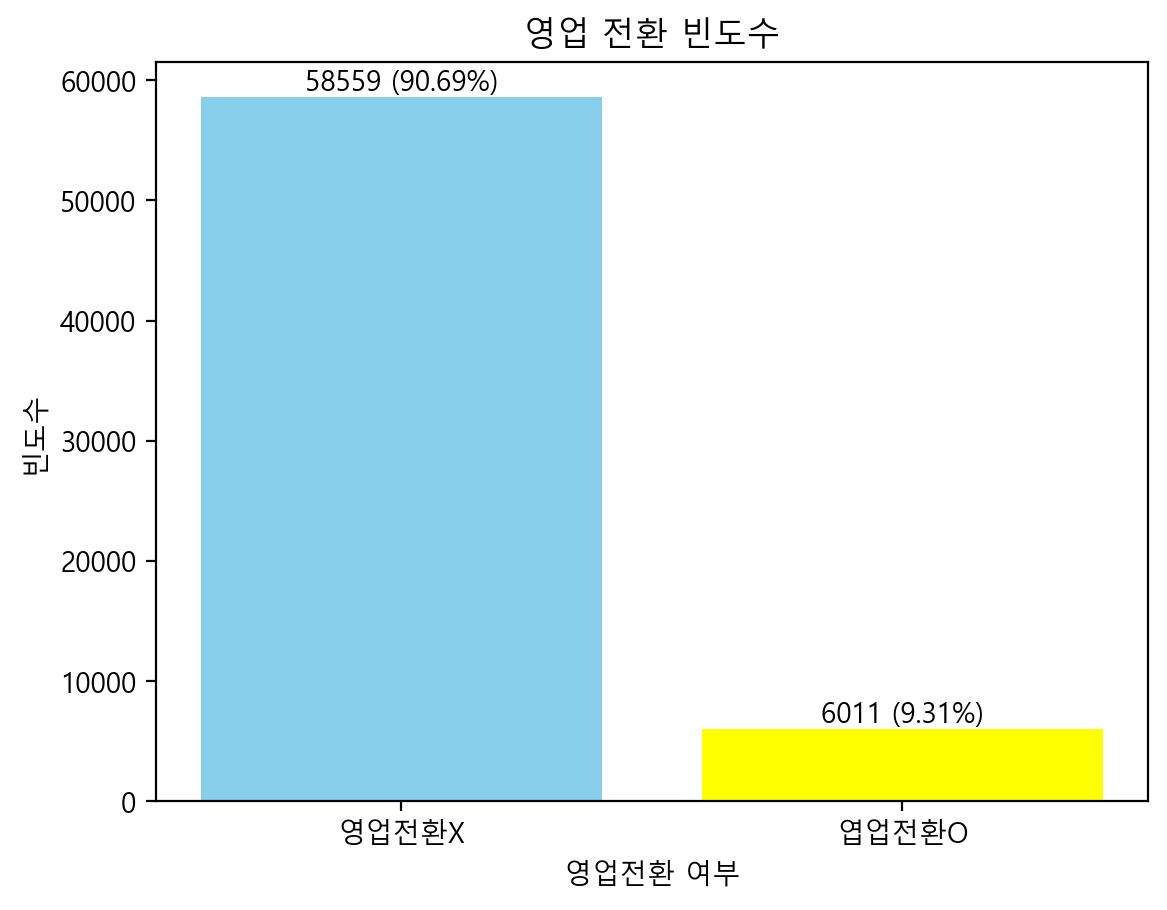

In [216]:
# 영업 성공 여부. True일 시 성공.
value_counts = df['is_converted'].value_counts()
total_samples = len(df)
percentage_conversion = value_counts / total_samples * 100 
bars = plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'yellow'])
plt.title('영업 전환 빈도수')
plt.xlabel('영업전환 여부')
plt.ylabel('빈도수')

# x 축 값 추가
plt.xticks(value_counts.index, labels=['영업전환X', '엽업전환O'])
for bar, count, percentage in zip(bars, value_counts.values, percentage_conversion.values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{count} ({percentage:.2f}%)", ha='center', va='bottom')

- bant_submitm(수치)

In [217]:
# MLQ 구성 요소 4가지 항목(BTNT)에 대해 작성된 값의 비율
# 영업 전환에 따른 고유값 분포
tmp1 = df.loc[df['is_converted'] == True, ['bant_submit']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['bant_submit']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
bant_submit,,,,,
1.00,1934,17197,10.1,19131,29.6
0.50,1012,16847,5.7,17859,27.7
0.25,1689,12685,11.8,14374,22.3
0.75,1216,11010,9.9,12226,18.9
0.00,160,820,16.3,980,1.5


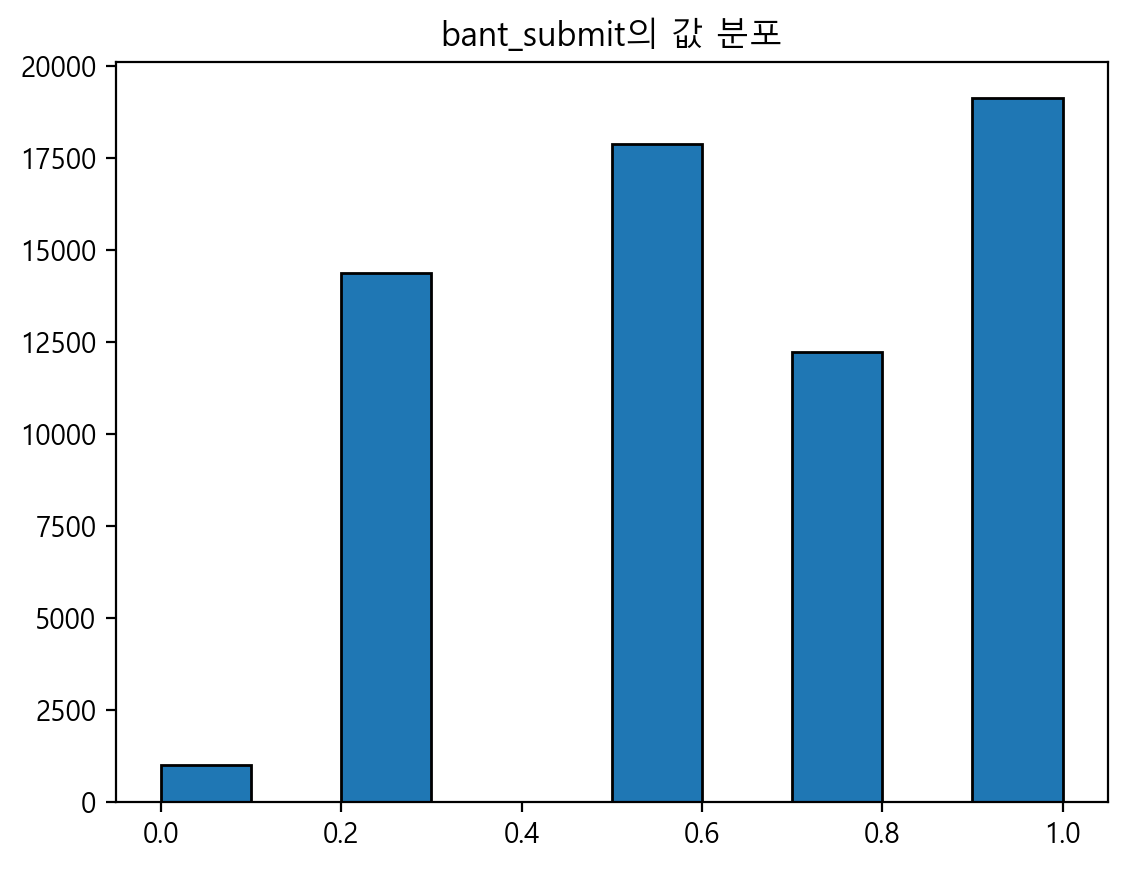

In [218]:
plt.hist(df['bant_submit'], bins=10, edgecolor='black')
plt.title('bant_submit의 값 분포')
plt.show()

- customer_country(범주)

In [219]:
# 고객의 국적
tmp1 = df.loc[df['is_converted'] == True, ['customer_country']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_country']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False) 

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_country,,,,,
//India,163.0,2892.0,5.3,3055.0,4.7
/São Paulo/Brazil,51.0,1325.0,3.7,1376.0,2.1
//United States,262.0,860.0,23.4,1122.0,1.7
//United Kingdom,8.0,799.0,1.0,807.0,1.2
//Saudi Arabia,33.0,686.0,4.6,719.0,1.1
...,...,...,...,...,...
/Lusaka/Lusaka/Zambia,NaN,1.0,NaN,NaN,NaN
/Luís Eduardo Magalhães/Brazil,NaN,1.0,NaN,NaN,NaN
/Lynnfield /United States,NaN,1.0,NaN,NaN,NaN


In [220]:
# 전처리 : 국가 값으로 값 변경
df['customer_country'] = df['customer_country'].str.split('/').str[-1].str.strip()

In [221]:
# 전처리 후 고객의 국적
tmp1 = df.loc[df['is_converted'] == True, ['customer_country']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_country']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_country,,,,,
India,1337.0,16418.0,7.5,17755.0,27.5
Brazil,818.0,8966.0,8.4,9784.0,15.2
United States,1141.0,3426.0,25.0,4567.0,7.1
Mexico,165.0,2768.0,5.6,2933.0,4.5
Philippines,315.0,2543.0,11.0,2858.0,4.4
,141.0,2077.0,6.4,2218.0,3.4
Colombia,93.0,1973.0,4.5,2066.0,3.2
U.A.E,231.0,1519.0,13.2,1750.0,2.7
Saudi Arabia,133.0,1439.0,8.5,1572.0,2.4


In [222]:
result.sort_values('convert_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_country,,,,,
Laos,2.0,1.0,66.7,3.0,0.0
Democratic Republic of the Congo,4.0,3.0,57.1,7.0,0.0
Cote d'Ivoire,4.0,3.0,57.1,7.0,0.0
Taiwan,26.0,24.0,52.0,50.0,0.1
Cameroon,3.0,3.0,50.0,6.0,0.0
bangalore,1.0,1.0,50.0,2.0,0.0
Gabon,2.0,2.0,50.0,4.0,0.0
Rio de Janeiro,1.0,1.0,50.0,2.0,0.0
Mali,1.0,1.0,50.0,2.0,0.0


- business_unit(범주)

In [223]:
# MQL 요청 상품에 대응되는 사업부
df['business_unit'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['business_unit']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['business_unit']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False) 

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
business_unit,,,,,
ID,3174.0,24731,11.4,27905.0,43.2
AS,1736.0,25448,6.4,27184.0,42.1
IT,1098.0,8085,12.0,9183.0,14.2
Solution,3.0,293,1.0,296.0,0.5
CM,NaN,2,NaN,NaN,NaN


- com_reg_ver_win_rate(수치)

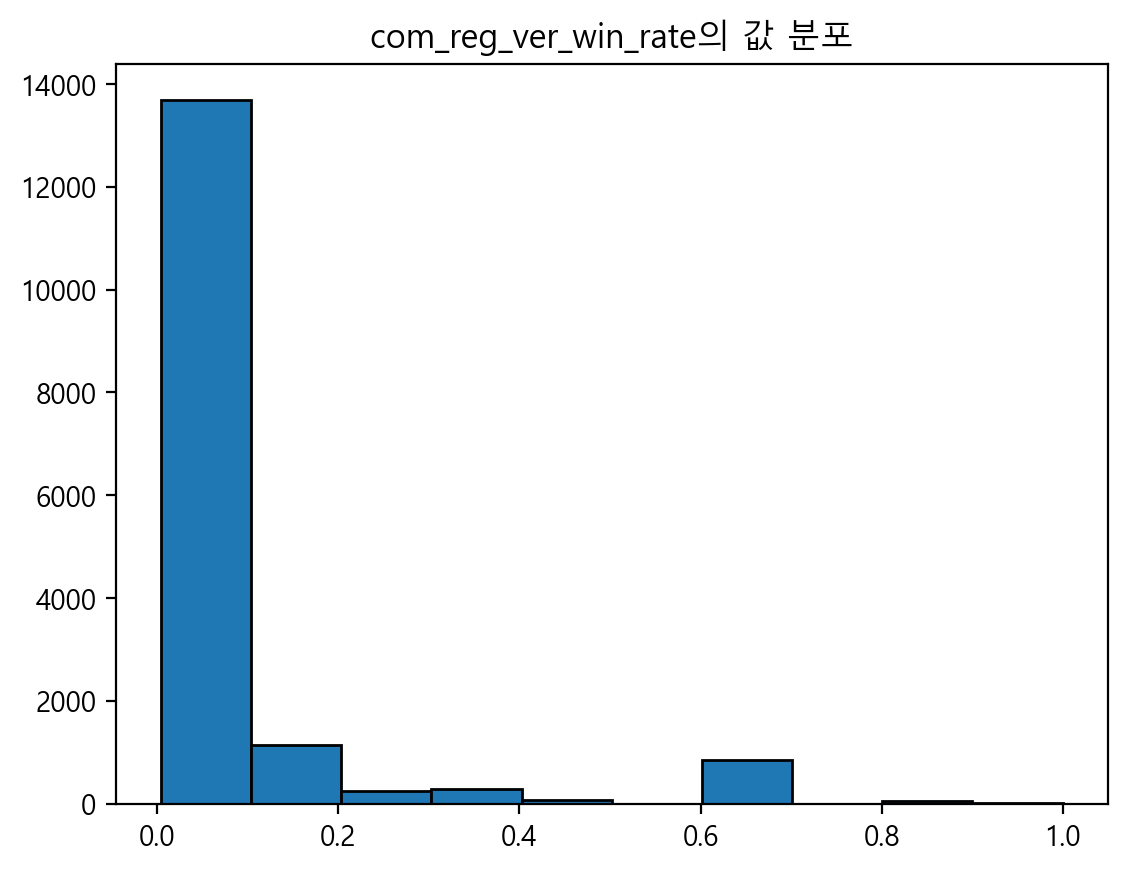

In [224]:
# Vertical Level 1, business unit, region을 기준으로 그룹화 후 oppty 비율
# 수직 레벨1, 비즈니스 단위, 지역에 따른 예상 매출 기회 비율
plt.hist(df['com_reg_ver_win_rate'], bins=10, edgecolor='black')
plt.title('com_reg_ver_win_rate의 값 분포')
plt.show()

In [225]:
correlation = round(df['is_converted'].corr(df['com_reg_ver_win_rate']),3) * 100
print("영업 전환 여부와의 상관 계수(전처리 전):", correlation)

영업 전환 여부와의 상관 계수(전처리 전): 30.3


- customer_idx(수치)

In [226]:
# 고객의 회사명
df['customer_idx'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['customer_idx']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_idx']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_idx,,,,,
47466,93.0,7956.0,1.2,8049.0,12.5
37680,5.0,376.0,1.3,381.0,0.6
18030,1.0,332.0,0.3,333.0,0.5
21321,1.0,172.0,0.6,173.0,0.3
19804,1.0,69.0,1.4,70.0,0.1
...,...,...,...,...,...
17803,NaN,1.0,NaN,NaN,NaN
17802,NaN,1.0,NaN,NaN,NaN
17801,NaN,1.0,NaN,NaN,NaN


In [227]:
result.sort_values('convert_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_idx,,,,,
45319,15.0,1.0,93.8,16.0,0.0
26337,13.0,1.0,92.9,14.0,0.0
5023,11.0,1.0,91.7,12.0,0.0
7740,17.0,2.0,89.5,19.0,0.0
14746,38.0,5.0,88.4,43.0,0.1
16481,7.0,1.0,87.5,8.0,0.0
9857,11.0,2.0,84.6,13.0,0.0
30009,5.0,1.0,83.3,6.0,0.0
45711,5.0,1.0,83.3,6.0,0.0


- customer_type(수치)

In [228]:
# 고객의 유형
df['customer_type'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['customer_type']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_type']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_type,,,,,
End-Customer,757.0,5891.0,11.4,6648.0,10.3
End Customer,1355.0,5094.0,21.0,6449.0,10.0
Specifier/ Influencer,405.0,2908.0,12.2,3313.0,5.1
Channel Partner,249.0,1446.0,14.7,1695.0,2.6
Service Partner,77.0,370.0,17.2,447.0,0.7
Solution Eco-Partner,166.0,126.0,56.8,292.0,0.5
Specifier / Influencer,15.0,28.0,34.9,43.0,0.1
Installer/Contractor,1.0,51.0,1.9,52.0,0.1
Consultant,11.0,4.0,73.3,15.0,0.0


In [229]:
# 전처리 : 중복명 및 통합
df['customer_type'].replace({'End Customer':'End-Customer', 'Specifier / Influencer': 'Specifier/Influencer',
                             'Home Owner':'Homeowner', 'Etc.':'Others','Other':'Others','End-user':'End-Customer',
                             'Commercial end-user':'End-Customer','Software / Solution Provider':'Software/Solution Provider',
                             'Dealer/Distributor	':'Distributor'}, 
                            inplace=True)


In [230]:
# 전처리 후 고객의 유형
tmp1 = df.loc[df['is_converted'] == True, ['customer_type']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_type']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_type,,,,,
End-Customer,2112.0,10994.0,16.1,13106.0,20.3
Specifier/ Influencer,405.0,2908.0,12.2,3313.0,5.1
Channel Partner,249.0,1446.0,14.7,1695.0,2.6
Service Partner,77.0,370.0,17.2,447.0,0.7
Solution Eco-Partner,166.0,126.0,56.8,292.0,0.5
Specifier/Influencer,15.0,28.0,34.9,43.0,0.1
Installer/Contractor,1.0,51.0,1.9,52.0,0.1
Consultant,11.0,4.0,73.3,15.0,0.0
Homeowner,3.0,12.0,20.0,15.0,0.0


In [231]:
# 파생변수
# 영업 전환율 높은 customer_type인 가중치1 부여
# tmp = result.sort_values('convert_ratio',ascending=False).head(9).reset_index()
# high_convert_customers = list(tmp['customer_type'])
high_convert_customers= ['Consultant', 'Solution Eco-Partner', 'Architect/Consultant', 'Specifier/Influencer', 'Homeowner', 'Service Partner', 'End-Customer', 'Channel Partner', 'Specifier/ Influencer']
df['important_customer_type'] = df['customer_type'].isin(high_convert_customers).astype(int)

- enterprise(수치)

In [232]:
# Global 기업인지, Small/Medium 규모의 기업인지
tmp1 = df.loc[df['is_converted'] == True, ['enterprise']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['enterprise']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
enterprise,,,,,
Enterprise,2693,38175,6.6,40868,63.3
SMB,3318,20384,14.0,23702,36.7


- historical_existing_cnt(수치)

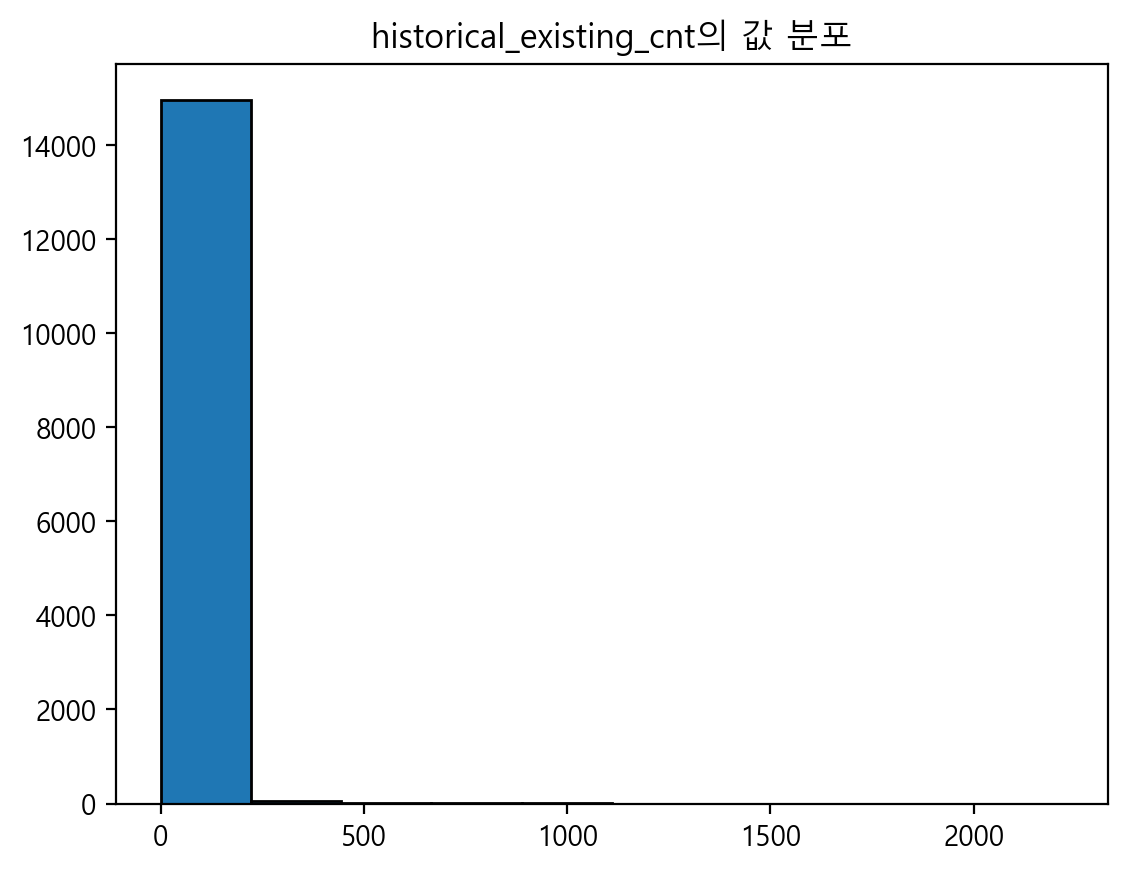

In [233]:
# 이전에 Converted(영업 전환) 되었던 횟수
plt.hist(df['historical_existing_cnt'], bins=10, edgecolor='black')
plt.title('historical_existing_cnt의 값 분포')
plt.show()

In [234]:
# 파생변수 : 과거 영업 전환 되었던 횟수가 100번 이상인 고객 인덱스
tmp_idx = df['historical_existing_cnt'].sort_values(ascending=False).head(1400).index
df['historical_convert_over_100'] = 0
df.loc[tmp_idx, 'historical_convert_over_100'] = 1
df['historical_convert_over_100'].value_counts()

historical_convert_over_100
0    63078
1     1492
Name: count, dtype: int64

- id_strategic_ver(수치)

In [235]:
# 특정 사업부(Business Unit), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여
df['id_strategic_ver'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['id_strategic_ver']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['id_strategic_ver']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
id_strategic_ver,,,,,
1.0,534,3503,13.2,4037,6.3


In [236]:
tmp = df.loc[df['id_strategic_ver'] == 1]
tmp['business_unit'].value_counts()

business_unit
ID    4037
Name: count, dtype: int64

In [237]:
tmp = df.loc[df['id_strategic_ver'] == 1]
tmp['business_area'].value_counts()

business_area
corporate / office       2903
hotel & accommodation    1134
Name: count, dtype: int64

- it_strategic_ver(수치)

In [238]:
# 특정 사업부(Business Unit), 특정 사업 영역(Vertical Level1)에 대해 가중치를 부여
df['it_strategic_ver'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['it_strategic_ver']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['it_strategic_ver']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
it_strategic_ver,,,,,
1.0,38,1136,3.2,1174,1.8


- idit_strategic_ver(수치)

In [239]:
# Id_strategic_ver이나 it_strategic_ver 값 중 하나라도 1의 값을 가지면 1 값으로 표현
df['idit_strategic_ver'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['idit_strategic_ver']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['idit_strategic_ver']].value_counts()
result_df2 = pd.DataFrame(tmp1).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
idit_strategic_ver,,,,,
1.0,572,572,50.0,1144,1.8


- customer_job(범주)

In [240]:
# 고객의 직업군
df['customer_job'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['customer_job']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_job']].value_counts()
result_df2 = pd.DataFrame(tmp1).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_job,,,,,
engineering,704,704,50.0,1408,2.2
administrative,405,405,50.0,810,1.3
information technology,388,388,50.0,776,1.2
purchasing,310,310,50.0,620,1.0
other,261,261,50.0,522,0.8
education,242,242,50.0,484,0.7
business development,208,208,50.0,416,0.6
sales,187,187,50.0,374,0.6
operations,178,178,50.0,356,0.6


- lead_desc_length(수치)

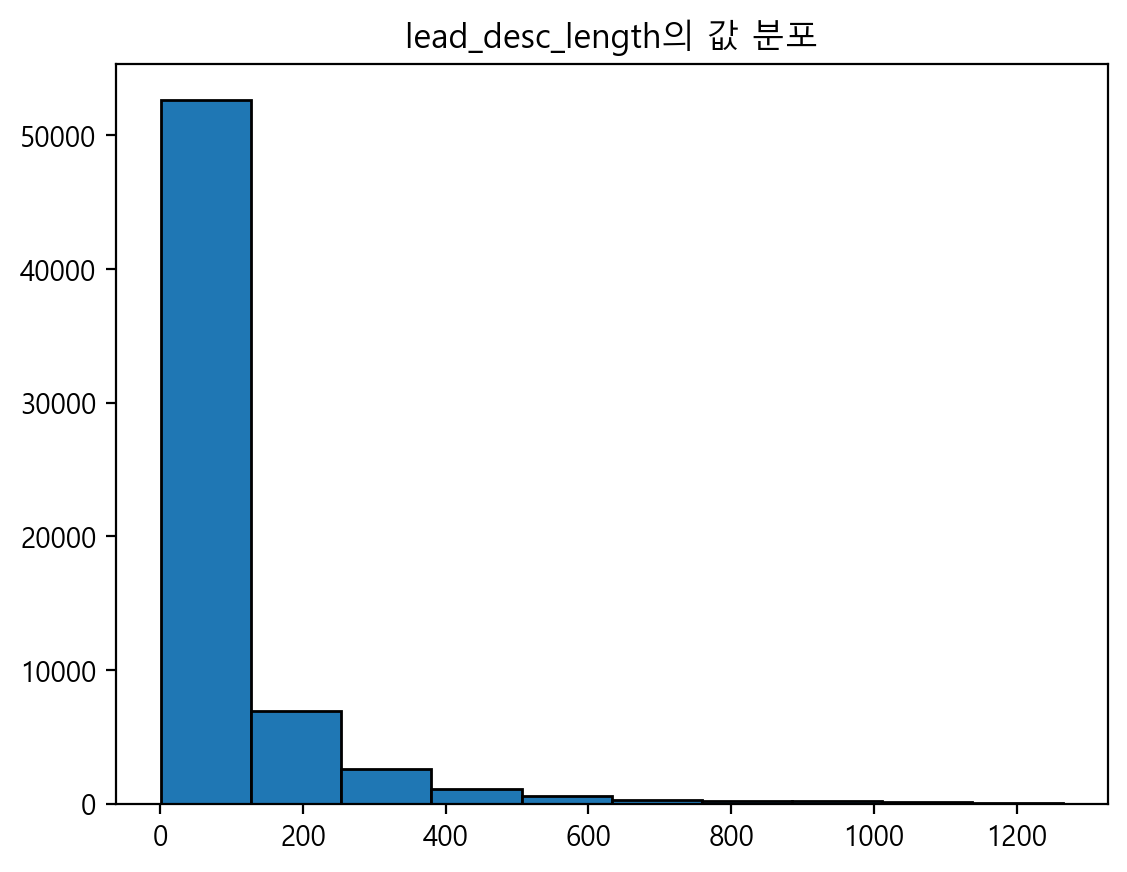

In [241]:
# 고객이 작성한 Lead Descriptoin 텍스트 총 길이
plt.hist(df['lead_desc_length'], bins=10, edgecolor='black')
plt.title('lead_desc_length의 값 분포')
plt.show()

- inquiry_type(범주)

In [242]:
# 전처리 : 중복 통합,오탈자 정리
df['inquiry_type'].replace({'Quotation or purchase consultation':'Quotation or Purchase Consultation',
                            'quotation_or_purchase_consultation':'Quotation or Purchase Consultation',
                            'Quotation or Purchase consultation':'Quotation or Purchase Consultation',
                            'Purchase or Quotation':'Quotation or Purchase Consultation',
                            'Others':'Other','other_':'Other','other':'Other','ETC.':'Other','Etc.':'Other','others':'Other',
                            'Usage or Technical Consultation':'Technical Consultation	',
                            'Usage or Technical Consultation':'Technical Consultation	',
                            'usage or technical consultation':'Technical Consultation	',
                            },
                            inplace=True)

In [243]:
# 고객의 문의 유형
df['inquiry_type'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['inquiry_type']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['inquiry_type']].value_counts()
result_df2 = pd.DataFrame(tmp1).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(5)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
inquiry_type,,,,,
Quotation or Purchase Consultation,4810,4810,50.0,9620,14.9
Sales Inquiry,559,559,50.0,1118,1.7
Other,55,55,50.0,110,0.2
Request for Partnership,49,49,50.0,98,0.2
Technical Consultation,46,46,50.0,92,0.1


In [244]:
result.sort_values('convert_ratio',ascending=False).head(5)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
inquiry_type,,,,,
Quotation or Purchase Consultation,4810,4810,50.0,9620,14.9
Sales Inquiry,559,559,50.0,1118,1.7
Hospital TV,1,1,50.0,2,0.0
Hotel TV products,1,1,50.0,2,0.0
One Quick:Flex,1,1,50.0,2,0.0


- product_category(범주)

In [245]:
# 요청 제품 카테고리
df['product_category'].value_counts()
df['inquiry_type'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['product_category']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['product_category']].value_counts()
result_df2 = pd.DataFrame(tmp1).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(5)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
product_category,,,,,
vrf,688,688,50.0,1376,2.1
video wall signage,424,424,50.0,848,1.3
led signage,396,396,50.0,792,1.2
multi-split,388,388,50.0,776,1.2
interactive signage,369,369,50.0,738,1.1


In [246]:
result.sort_values('convert_ratio',ascending=False).head(5)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
product_category,,,,,
vrf,688,688,50.0,1376,2.1
video wall signage,424,424,50.0,848,1.3
cac,1,1,50.0,2,0.0
climatiseur résidentiel,1,1,50.0,2,0.0
digital signage or commercial tvs,1,1,50.0,2,0.0


- product_subcategory(범주)

In [247]:
# 요청 제품 하위 카테고리
df['product_subcategory'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['product_subcategory']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['product_subcategory']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(5)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
product_subcategory,,,,,
Interactive Digital Board,89.0,357.0,20.0,446.0,0.7
All Medical Displays,9.0,438.0,2.0,447.0,0.7
TR3BF Series,50.0,327.0,13.3,377.0,0.6
Diagnostic Monitors,12.0,281.0,4.1,293.0,0.5
Transparent LED Film,47.0,285.0,14.2,332.0,0.5


- product_modelname(범주)

In [248]:
# 전처리 : 값에 국가가 존재하면 값에서 제거 후 대체
df['product_modelname'] = df['product_modelname'].str.replace(r'\(NA\)|\(MEA\)|\(EU\)|\(EU/CIS\)|\(ASIA\)|\(INDIA\)|\(CIS\)|\(Colombia\)|\(SCA\)|\(EU Only\)|\(Brazil Only\)|\(LATAM\)|\(Japan\)', '', regex=True).str.strip()
# 전처리 : 모델명과 모델 코드 모두 존재하면 모델 코드로 대체
df['product_modelname'].replace({'UltraWide Ergo(34WN780)':'34WN780','UltraFine Ergo(32UN880)':'32UN880',
                                     'DualUp(28MQ780)':'28MQ780','Ergo Dual(27QP88D)':'27QP88D','UltraWide Ergo(34WN780)	':'34WN780'
                                     },inplace=True)
# 전처리 : 세부 모델명 삭제
hash_dash = df['product_modelname'].str.contains('-', na=False)
df.loc[hash_dash, 'product_modelname'] = df.loc[hash_dash, 'product_modelname'].str.split('-').str[-2]

In [249]:
# 요청 제품 모델명
df['product_modelname'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['product_modelname']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['product_modelname']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result = result.sort_values('value_ratio',ascending=False).reset_index()
result.head(5)

,product_modelname,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
0,43HT3WJ,34.0,261.0,11.5,295.0,0.5
1,55CT5WJ,44.0,237.0,15.7,281.0,0.4
2,55VSM5J,56.0,161.0,25.8,217.0,0.3
3,49VL5G,42.0,177.0,19.2,219.0,0.3
4,55VSH7J,35.0,136.0,20.5,171.0,0.3


- customer_country.1(범주)

In [250]:
# 담당 자사 법인명 기반의 지역 정보(대륙)
# customer_country와 겹치므로 행 제거
df.drop(columns = ['customer_country.1'],inplace=True)

- customer_position(범주)

In [251]:
# 고객의 회사 직책
df['customer_position'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['customer_position']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['customer_position']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False).head(5)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
customer_position,,,,,
none,2146.0,19491.0,9.9,21637.0,33.5
manager,955.0,7988.0,10.7,8943.0,13.9
ceo/founder,790.0,7787.0,9.2,8577.0,13.3
other,417.0,6107.0,6.4,6524.0,10.1
director,513.0,4673.0,9.9,5186.0,8.0


- response_corporate(범주)

In [252]:
# 담당 자사 법인명
df['response_corporate'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['response_corporate']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['response_corporate']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result = result.fillna(0)
result.sort_values('value_ratio',ascending=False).head(10)

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
response_corporate,,,,,
LGEIL,1354.0,16461,7.6,17815.0,27.6
LGESP,933.0,9423,9.0,10356.0,16.0
LGEUS,1348.0,5616,19.4,6964.0,10.8
LGEPH,317.0,2623,10.8,2940.0,4.6
LGEMS,163.0,2786,5.5,2949.0,4.6
LGEGF,286.0,2014,12.4,2300.0,3.6
LGECB,98.0,2107,4.4,2205.0,3.4
LGEUK,33.0,1660,1.9,1693.0,2.6
LGESJ,134.0,1437,8.5,1571.0,2.4


In [253]:
# 파생변수 : 영업 전환율 기준으로 상(20%~), 중(10%~20%), 하(~10%)로 담당 자사 구분
high_cor = []
medium_cor = []
low_cor = []
result = result.reset_index()

for index, row in result.iterrows():
    if row['convert_ratio'] >= 20:
        high_cor.append(row['response_corporate'])
    elif 10 <= row['convert_ratio'] < 20:
        medium_cor.append(row['response_corporate'])
    else:
        low_cor.append(row['response_corporate'])

high_cor = list(set(high_cor))
medium_cor = list(set(medium_cor))
low_cor = list(set(low_cor))

high_cor = ['LGEHK', 'LGETT', 'LGEAF', 'LGECZ', 'LGERO', 'LGEMC', 'LGELA']
medium_cor = ['LGEIN', 'LGEPH', 'LGETH', 'LGESA', 'LGEGF', 'LGEUS', 'LGEPT', 'LGEAR', 'LGEHS', 'LGEAP', 'LGESL']
low_cor = ['LGECB', 'LGEML', 'LGEPS', 'LGEIR', 'LGEEB', 'LGELF', 'LGEVH', 'LGEES', 'LGEPR', 'LGEIS', 'LGEAS', 'LGEUR', 'LGEYK', 'LGEEG', 'LGECH', 'LGECI', 'LGEIL', 'LGECL', 'LGESP', 'LGERA', 'LGEKR', 'LGESJ', 'LGEBT', 'LGEJP', 'LGEAG', 'LGEMK', 'LGEFS', 'LGEBN', 'LGEPL', 'LGEUK', 'LGETK', 'LGEMS', 'LGEEF', 'LGESW', 'LGEDG']
df['corporate_rank'] = 0
high_cor_row = df['response_corporate'].isin(high_cor)
df.loc[high_cor_row,'corporate_rank'] = 2
medium_cor_row = df['response_corporate'].isin(medium_cor)
df.loc[medium_cor_row,'corporate_rank'] = 1
low_cor_row = df['response_corporate'].isin(low_cor)
df.loc[low_cor_row,'corporate_rank'] = 0

df['corporate_rank'].value_counts()

corporate_rank
0    49056
1    14659
2      855
Name: count, dtype: int64

- excepted_timeline(범주)

In [254]:
# 고객의 요청한 처리 일정
df['expected_timeline'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['expected_timeline']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['expected_timeline']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result = result.reset_index()
result = result.fillna(0)
result = result.sort_values('value_ratio',ascending=False)  
result.sort_values('convert_ratio',ascending=False).head(5)

,expected_timeline,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
10,december 2022,2.0,1.0,66.7,3.0,0.0
31,less than 5 months,1.0,1.0,50.0,2.0,0.0
102,fu under progress.,1.0,1.0,50.0,2.0,0.0
21,october 2022,1.0,1.0,50.0,2.0,0.0
23,november 2022,1.0,1.0,50.0,2.0,0.0


In [255]:
# 전처리 : klue-bert 기반 감정점수 변환
# ex : 6 months ~ 9 months, october 2022, not interested, call back later, followed up 

- ver_cus(수치)

In [256]:
# 특정 Vertical Level 1이면서 Customer_type이 소비자인 경우에 대한 가중치
df['ver_cus'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['ver_cus']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['ver_cus']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
ver_cus,,,,,
0,5326,56003,8.7,61329,95.0
1,685,2556,21.1,3241,5.0


In [257]:
# Vertical Level 1(특정 사업 영역)
tmp = df.loc[df['ver_cus'] == 1]
tmp['business_area'].value_counts()

business_area
corporate / office       1495
retail                    933
education                 565
hotel & accommodation     248
Name: count, dtype: int64

In [258]:
# Customer(특정 고객 영역)
tmp['customer_type'].value_counts()

customer_type
End-Customer    3241
Name: count, dtype: int64

- ver_pro(수치)

In [259]:
# 특정 Vertical Level 1이면서 특정 Product Category인 경우에 대한 가중치
df['ver_pro'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['ver_pro']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['ver_pro']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('value_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
ver_pro,,,,,
0,5570,55558,9.1,61128,94.7
1,441,3001,12.8,3442,5.3


In [260]:
# Vertical Level 1(특정 사업 영역)
tmp = df.loc[df['ver_pro'] == 1]
tmp['business_area'].value_counts()

business_area
corporate / office       1767
retail                   1321
hotel & accommodation     354
Name: count, dtype: int64

In [261]:
# product category(특정 카테고리)
tmp['product_category'].value_counts()

product_category
led signage                                                                                             755
video wall signage                                                                                      729
interactive signage                                                                                     453
oled signage                                                                                            419
standard signage                                                                                        390
hotel tv                                                                                                354
high brightness signage                                                                                 217
special signage                                                                                          52
signage care solution                                                                                    17
monitor sig

- ver_win_rate_x(수치)

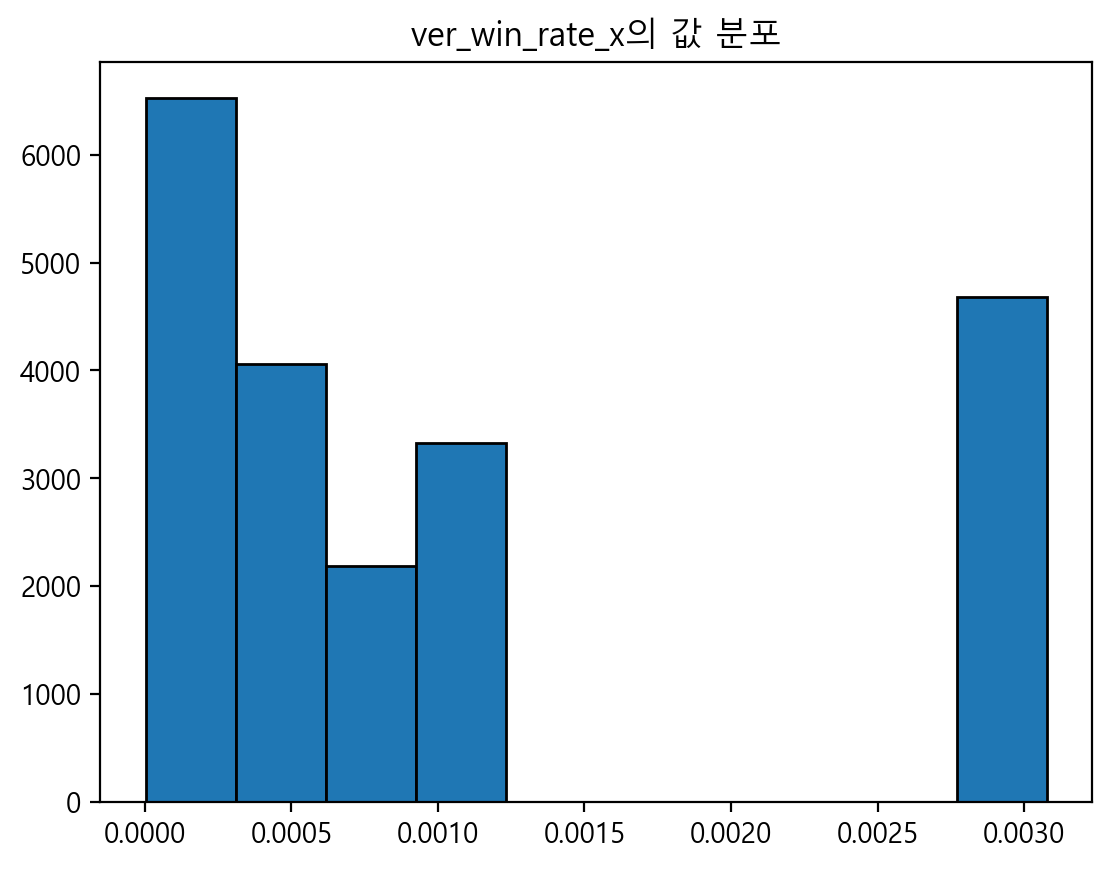

In [262]:
# 전체 Lead 중에서 Vertical을 기준으로 Vertical 수 비율과 Vertical 별 Lead 수 대비 영업 전환 성공 비율 값을 곱한 값
plt.hist(df['ver_win_rate_x'], bins=10, edgecolor='black')
plt.title('ver_win_rate_x의 값 분포')
plt.show()

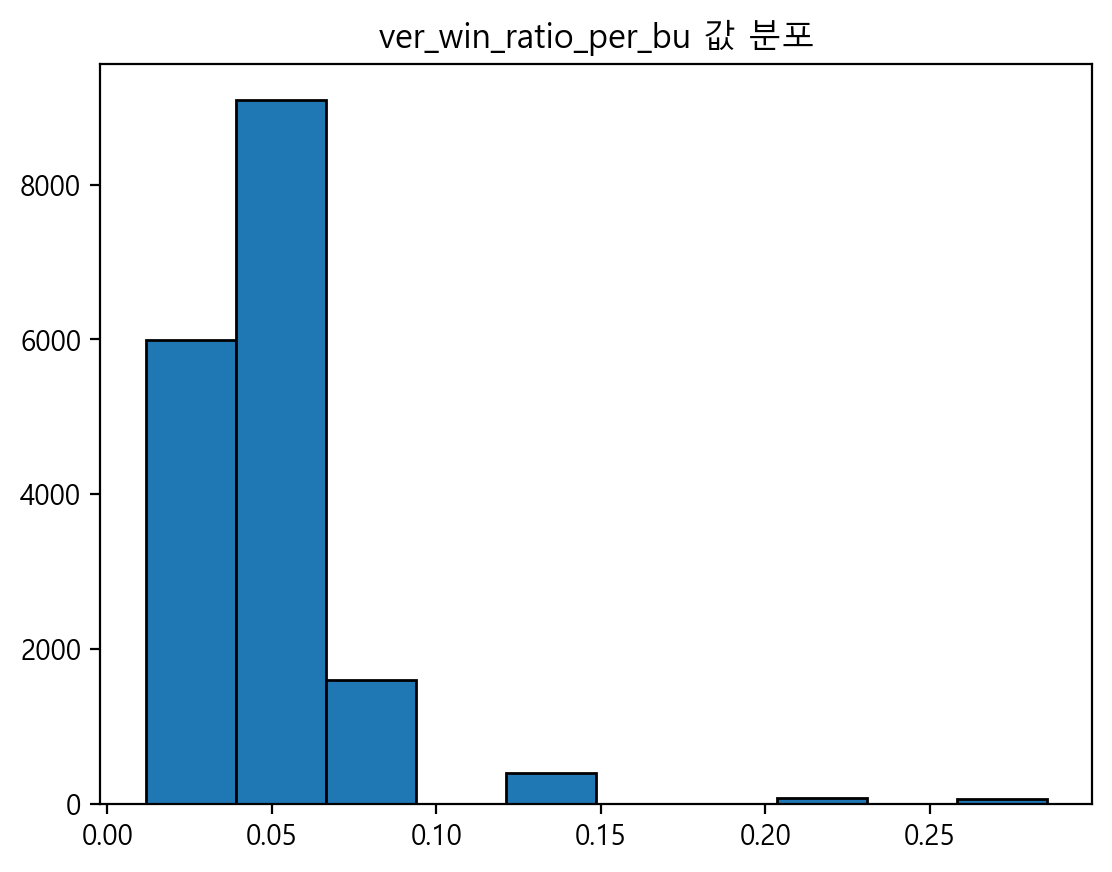

In [263]:
# 	특정 Vertical Level1의 Business Unit 별 샘플 수 대비 영업 전환된 샘플 수의 비율을 계산
df['ver_win_ratio_per_bu'].value_counts()
plt.hist(df['ver_win_ratio_per_bu'], bins=10, edgecolor='black')
plt.title('ver_win_ratio_per_bu 값 분포')
plt.show()

- business_area

In [296]:
# 고객의 사업 영역
df['business_area'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['business_area']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['business_area']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result.sort_values('convert_ratio',ascending=False)  

,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
business_area,,,,,
transportation,261,476,35.4,737,1.1
hospital & health care,416,916,31.2,1332,2.1
power plant / renewable energy,26,118,18.1,144,0.2
corporate / office,446,4232,9.5,4678,7.2
factory,105,1007,9.4,1112,1.7
public facility,49,518,8.6,567,0.9
hotel & accommodation,187,2003,8.5,2190,3.4
education,170,1869,8.3,2039,3.2
government department,58,640,8.3,698,1.1


In [299]:
# 전처리 : 최빈값 대체
df['business_area'] = df['business_area'].fillna('Others')

- 파생변수 생성

In [272]:
# 파생변수 : 영업 전환율 Top3 사업영역 여부
top3_bu_area = ['transportation','hospital & health care','power plant / renewable energy']
df['top3_convert_bu_area'] = df['business_area'].isin(top3_bu_area).astype(int)

In [273]:
df['top3_convert_bu_area'].value_counts()

top3_convert_bu_area
0    62357
1     2213
Name: count, dtype: int64

- business_subarea

In [305]:
# 고객의 세부 사업 영역
df['business_subarea'].value_counts()
tmp1 = df.loc[df['is_converted'] == True, ['business_subarea']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['business_subarea']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result = result.fillna(0)
result = result.reset_index()
result.sort_values('convert_ratio',ascending=False).head(5)  

,business_subarea,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
66,Dormitory,2.0,1.0,66.7,3.0,0.0
63,Holdings,2.0,1.0,66.7,3.0,0.0
35,Railway & Metro Station,6.0,4.0,60.0,10.0,0.0
3,Cruise,49.0,33.0,59.8,82.0,0.1
43,F&B(Food and Beverage),5.0,5.0,50.0,10.0,0.0


In [300]:
# 전처리 : 최빈값 대체
df['business_subarea'] = df['business_subarea'].fillna('Others')

In [321]:
high_convert_bu_subarea_li = ['Dormitory', 'Holdings', 'Railway & Metro Station', 'Cruise', 'F&B(Food and Beverage)', 'Hotel', 'Broadcasting & Media', 'Cinema /Theater', 'Hospital', 'Police / Fire station', 'QSR(Quick Service Restaurant)', 'Resort', 'Investment', 'Outdoor Advertisement', 'Exhibition / Convention Center', 'Townhouse', 'Power Plant']
df['high_convert_bu_subarea_li'] = 0

['Dormitory', 'Holdings', 'Railway & Metro Station', 'Cruise', 'F&B(Food and Beverage)', 'Hotel', 'Broadcasting & Media', 'Cinema /Theater', 'Hospital', 'Police / Fire station', 'QSR(Quick Service Restaurant)', 'Resort', 'Investment', 'Outdoor Advertisement', 'Exhibition / Convention Center', 'Townhouse', 'Power Plant']


- lead_owner

In [266]:
# 영업 담당자 이름
tmp1 = df.loc[df['is_converted'] == True, ['lead_owner']].value_counts()
result_df1 = pd.DataFrame(tmp1).rename(columns={'count':'convert_count'})
tmp2 = df.loc[df['is_converted'] == False, ['lead_owner']].value_counts()
result_df2 = pd.DataFrame(tmp2).rename(columns={'count':'not_convert_count'})
result = pd.concat([result_df1,result_df2],axis=1)
result['convert_ratio'] = round(result['convert_count'] / (result['convert_count'] + result['not_convert_count']),3)*100
result['value_count'] = (result['convert_count'] + result['not_convert_count'])
result['value_ratio'] = round((result['convert_count'] + result['not_convert_count']) / len(df),3)*100
result = result.reset_index()
result = result.fillna(0)
result.sort_values('value_ratio',ascending=False)  

,lead_owner,convert_count,not_convert_count,convert_ratio,value_count,value_ratio
22,174,50.0,4934.0,1.0,4984.0,7.7
5,97,91.0,3096.0,2.9,3187.0,4.9
48,23,31.0,2422.0,1.3,2453.0,3.8
192,194,7.0,2332.0,0.3,2339.0,3.6
291,42,3.0,1296.0,0.2,1299.0,2.0
...,...,...,...,...,...,...
513,217,1.0,8.0,11.1,9.0,0.0
515,105,1.0,15.0,6.2,16.0,0.0
518,99,1.0,5.0,16.7,6.0,0.0
519,228,1.0,1.0,50.0,2.0,0.0


In [267]:
# 파생변수 : 영업 전환율 기준으로 상(40%~), 중(10%~40%), 하(~10%)로 담당 자사 구분
high_cor = []
medium_cor = []
low_cor = []
result = result.reset_index()

for index, row in result.iterrows():
    if row['convert_ratio'] >= 40:
        high_cor.append(row['lead_owner'])
    elif 10 <= row['convert_ratio'] < 40:
        medium_cor.append(row['lead_owner'])
    else:
        low_cor.append(row['lead_owner'])

high_cor = list(set(high_cor))
medium_cor = list(set(medium_cor))
low_cor = list(set(low_cor))

df['lead_owner_rank'] = 0
high_cor_row = df['lead_owner'].isin(high_cor)
df.loc[high_cor_row,'lead_owner_rank'] = 2
medium_cor_row = df['lead_owner'].isin(medium_cor)
df.loc[medium_cor_row,'lead_owner_rank'] = 1
low_cor_row = df['lead_owner'].isin(low_cor)
df.loc[low_cor_row,'corporate_rank'] = 0

df['lead_owner_rank'].value_counts()

lead_owner_rank
0    47981
1    12388
2     4201
Name: count, dtype: int64

## 2. 데이터 전처리
- 학습 데이터와 테스트 데이터 동일한 방식으로 전처리
- 단, 데이터는 분리한 후 전처리 진행(일반화 성능 발휘 가능)

### 결측값 처리

- 중위값으로 대체

In [209]:
# train data
df_train['com_reg_ver_win_rate'] = df_train['com_reg_ver_win_rate'].fillna(df_train['com_reg_ver_win_rate'].median())
df_train['historical_existing_cnt'] = df_train['historical_existing_cnt'].fillna(df_train['historical_existing_cnt'].median())
df_train['ver_win_rate_x'] = df_train['ver_win_rate_x'].fillna(df_train['ver_win_rate_x'].median())
df_train['ver_win_ratio_per_bu'] = df_train['ver_win_ratio_per_bu'].fillna(df_train['ver_win_ratio_per_bu'].median())

# test data
df_test['com_reg_ver_win_rate'] = df_test['com_reg_ver_win_rate'].fillna(df_test['com_reg_ver_win_rate'].median())
df_test['historical_existing_cnt'] = df_test['historical_existing_cnt'].fillna(df_test['historical_existing_cnt'].median())
df_test['ver_win_rate_x'] = df_test['ver_win_rate_x'].fillna(df_test['ver_win_rate_x'].median())
df_test['ver_win_ratio_per_bu'] = df_test['ver_win_ratio_per_bu'].fillna(df_test['ver_win_ratio_per_bu'].median())

- 특정 값으로 대체

In [210]:
# train data
df_train['customer_type'] = df_train['customer_type'].fillna('other')
df_train['id_strategic_ver'] = df_train['id_strategic_ver'].fillna(0)
df_train['it_strategic_ver'] = df_train['it_strategic_ver'].fillna(0)
df_train['idit_strategic_ver'] = df_train['idit_strategic_ver'].fillna(0)
df_train['customer_job'] = df_train['customer_job'].fillna('other')
df_train['inquiry_type'] = df_train['inquiry_type'].fillna('other')
df_train['product_category'] = df_train['product_category'].fillna('etc.')
df_train['product_subcategory'] = df_train['product_subcategory'].fillna('etc.')
df_train['product_modelname'] = df_train['product_modelname'].fillna('etc.')
df_train['ver_cus'] = df_train['ver_cus'].fillna(0)
df_train['ver_pro'] = df_train['ver_pro'].fillna(0)
df_train['business_area'] = df_train['business_area'].fillna('others')
df_train['business_subarea'] = df_train['business_subarea'].fillna('others')
df_train['customer_country'] = df_train['customer_country'].fillna('other')
df_train['customer_country.1'] = df_train['customer_country.1'].fillna('other')
df_train['expected_timeline'] = df_train['expected_timeline'].fillna(df_train['expected_timeline'].mode().loc[0])

# test data
df_test['customer_type'] = df_test['customer_type'].fillna('other')
df_test['id_strategic_ver'] = df_test['id_strategic_ver'].fillna(0)
df_test['it_strategic_ver'] = df_test['it_strategic_ver'].fillna(0)
df_test['idit_strategic_ver'] = df_test['idit_strategic_ver'].fillna(0)
df_test['customer_job'] = df_test['customer_job'].fillna('other')
df_test['inquiry_type'] = df_test['inquiry_type'].fillna('other')
df_test['product_category'] = df_test['product_category'].fillna('etc.')
df_test['product_subcategory'] = df_test['product_subcategory'].fillna('etc.')
df_test['product_modelname'] = df_test['product_modelname'].fillna('etc.')
df_test['ver_cus'] = df_test['ver_cus'].fillna(0)
df_test['ver_pro'] = df_test['ver_pro'].fillna(0)
df_test['business_area'] = df_test['business_area'].fillna('others')
df_test['business_subarea'] = df_test['business_subarea'].fillna('others')
df_test['expected_timeline'] = df_test['expected_timeline'].fillna(df_test['expected_timeline'].mode().loc[0])

### 이상치 처리

- IQR 이용해서 이상치 처리

In [211]:
def replace_outliers_with_median(df, columns):
    df_no_outliers = df.copy()  # 원본 데이터프레임을 변경하지 않기 위해 복사본 생성
    
    for column in columns:
        Q1 = df_no_outliers[column].quantile(0.25)
        Q3 = df_no_outliers[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # 이상치 범위 계산
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # 이상치를 중위값으로 대체
        df_no_outliers.loc[(df_no_outliers[column] < lower_bound) | (df_no_outliers[column] > upper_bound), column] = df_no_outliers[column].median()
      
    return df_no_outliers

- 이상치 처리전 분포

In [212]:
df_train.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,id
count,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,59299.000000,0.0
mean,0.634593,0.059622,27114.556333,7.691260,0.058079,0.018904,0.076983,79.271590,0.041603,0.050810,0.000741,0.049698,262.563888,NaN
std,0.286066,0.077040,14653.911888,22.551131,0.233894,0.136188,0.266566,132.551067,0.199681,0.219612,0.000665,0.014200,231.605681,NaN
min,0.000000,0.003788,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000002,0.011583,0.000000,NaN
25%,0.500000,0.049180,14913.000000,4.000000,0.000000,0.000000,0.000000,7.000000,0.000000,0.000000,0.000572,0.049840,97.000000,NaN
50%,0.500000,0.049180,26774.000000,4.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.000000,0.000572,0.049840,175.000000,NaN
75%,1.000000,0.049180,40368.500000,4.000000,0.000000,0.000000,0.000000,92.000000,0.000000,0.000000,0.000572,0.049840,374.000000,NaN
max,1.000000,1.000000,47466.000000,1394.000000,1.000000,1.000000,1.000000,1264.000000,1.000000,1.000000,0.003079,0.285714,1114.000000,NaN


In [213]:
# 수치형 변수 리스트
numeric_col = df_train.select_dtypes('number').columns.to_list()

# 학습 데이터 이상치 처리
df_train = replace_outliers_with_median(df_train, numeric_col)
# 테스트 데이터 이상치 처리
df_test = replace_outliers_with_median(df_test, numeric_col)

- 이상치 처리 후 분포

In [214]:
df_train.describe()

,bant_submit,com_reg_ver_win_rate,customer_idx,historical_existing_cnt,id_strategic_ver,it_strategic_ver,idit_strategic_ver,lead_desc_length,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,lead_owner,id
count,59299.000000,5.929900e+04,59299.000000,59299.0,59299.0,59299.0,59299.0,59299.000000,59299.0,59299.0,5.929900e+04,5.929900e+04,59299.000000,0.0
mean,0.634593,4.918033e-02,27114.556333,4.0,0.0,0.0,0.0,43.627903,0.0,0.0,5.719551e-04,4.984026e-02,230.518727,NaN
std,0.286066,6.307508e-15,14653.911888,0.0,0.0,0.0,0.0,49.417551,0.0,0.0,3.868466e-16,2.679130e-14,188.378391,NaN
min,0.000000,4.918033e-02,2.000000,4.0,0.0,0.0,0.0,1.000000,0.0,0.0,5.719551e-04,4.984026e-02,0.000000,NaN
25%,0.500000,4.918033e-02,14913.000000,4.0,0.0,0.0,0.0,7.000000,0.0,0.0,5.719551e-04,4.984026e-02,97.000000,NaN
50%,0.500000,4.918033e-02,26774.000000,4.0,0.0,0.0,0.0,29.000000,0.0,0.0,5.719551e-04,4.984026e-02,175.000000,NaN
75%,1.000000,4.918033e-02,40368.500000,4.0,0.0,0.0,0.0,60.000000,0.0,0.0,5.719551e-04,4.984026e-02,341.000000,NaN
max,1.000000,4.918033e-02,47466.000000,4.0,0.0,0.0,0.0,219.000000,0.0,0.0,5.719551e-04,4.984026e-02,789.000000,NaN


### 스케일링

In [36]:
# # train data scaling
# scaler = MinMaxScaler()
# scaler.fit(df_train[numeric_col])
# df_train[numeric_col] = scaler.transform(df_train[numeric_col])
# df_train[numeric_col] = pd.DataFrame(df_train[numeric_col])

# # test data scaling
# scaler = MinMaxScaler()
# scaler.fit(df_test[numeric_col])
# df_test[numeric_col] = scaler.transform(df_test[numeric_col])
# df_test[numeric_col] = pd.DataFrame(df_test[numeric_col])

### 레이블 인코딩

In [269]:
def label_encoding(series: pd.Series) -> pd.Series:

    my_dict = {}
    series = series.astype(str)
    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [65]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]
for col in label_columns:
    df[col] = label_encoding(df[col])

- 상관관계 확인

In [72]:
# train data : target과의 상관관계
df_train.corr()['is_converted'].sort_values(ascending=False)

is_converted               1.000000
lead_desc_length           0.131830
enterprise                 0.124941
lead_owner                 0.081668
business_unit              0.072386
product_category           0.048535
customer_country           0.037218
customer_country.1         0.037218
response_corporate         0.020834
expected_timeline          0.005072
bant_submit               -0.002480
inquiry_type              -0.013303
customer_job              -0.017534
customer_position         -0.023349
business_area             -0.023360
customer_idx              -0.056425
product_modelname         -0.067743
product_subcategory       -0.080168
business_subarea          -0.101764
customer_type             -0.102505
com_reg_ver_win_rate            NaN
historical_existing_cnt         NaN
id_strategic_ver                NaN
it_strategic_ver                NaN
idit_strategic_ver              NaN
ver_cus                         NaN
ver_pro                         NaN
ver_win_rate_x              

In [73]:
# test data : target 과의 상관관계
df_test.corr()['is_converted'].sort_values(ascending=False)

is_converted               1.000000
business_unit              0.196607
lead_desc_length           0.148206
response_corporate         0.142132
enterprise                 0.120172
customer_country.1         0.068110
customer_country           0.068110
lead_owner                 0.055416
customer_job               0.045746
business_area              0.044812
expected_timeline          0.001934
bant_submit               -0.000490
customer_position         -0.005131
id                        -0.009617
product_category          -0.015792
product_modelname         -0.045899
customer_idx              -0.061679
product_subcategory       -0.067726
inquiry_type              -0.088831
customer_type             -0.121785
business_subarea          -0.205642
com_reg_ver_win_rate            NaN
historical_existing_cnt         NaN
id_strategic_ver                NaN
it_strategic_ver                NaN
idit_strategic_ver              NaN
ver_cus                         NaN
ver_pro                     

## 3. 모델 학습

### 3-1. 학습, 검증 데이터 분리

In [ ]:
df_train = df.iloc[: len(df_train)]
df_test = df.iloc[len(df_train) :]

In [42]:
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)

In [43]:
model = DecisionTreeClassifier()

### 3-2. 모델 훈련

In [44]:
model.fit(x_train.fillna(0), y_train)

DecisionTreeClassifier()

## 4. 교차 검증 및 앙상블

## 5. 파라미터 튜닝

## 6. 모델 평가

In [45]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [46]:
pred = model.predict(x_val.fillna(0))
get_clf_eval(y_val, pred)

오차행렬:
 [[  729   218]
 [  266 10647]]

정확도: 0.9592
정밀도: 0.7327
재현율: 0.7698
F1: 0.7508


## 7. 예측 및 제출

In [47]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [48]:
test_pred = model.predict(x_test.fillna(0))
sum(test_pred) # True로 예측된 개수

1179

In [49]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = test_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)